In [1]:
from spatial.merfish_dataset import FilteredMerfishDataset, MerfishDataset
from spatial.models.monet_ae import MonetAutoencoder2D, TrivialAutoencoder
from spatial.train import train
from spatial.predict import test

import time
import json
import numpy as np

import torch

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

In [2]:
# read in merfish dataset and get columns names
import pandas as pd

# get relevant data stuff
df_file = pd.ExcelFile("~/spatial/data/messi.xlsx")
messi_df = pd.read_excel(df_file, "All.Pairs")
merfish_df = pd.read_csv("~/spatial/data/raw/merfish.csv")
merfish_df = merfish_df.drop(['Blank_1', 'Blank_2', 'Blank_3', 'Blank_4', 'Blank_5', 'Fos'], axis=1)

# these are the 13 ligands or receptors found in MESSI
non_response_genes = ['Cbln1', 'Cxcl14', 'Crhbp', 'Gabra1', 'Cbln2', 'Gpr165', 
                      'Glra3', 'Gabrg1', 'Adora2a', 'Vgf', 'Scg2', 'Cartpt',
                      'Tac2']
# this list stores the control genes aka "Blank_{int}"
blank_genes = []

# we will populate all of the non-response genes as being in one or the other
# the ones already filled in come from the existing 13 L/R genes above
ligands = ["Cbln1", "Cxcl14", "Cbln2", "Vgf", "Scg2", "Cartpt", "Tac2"]
receptors = ["Crhbp", "Gabra1", "Gpr165", "Glra3", "Gabrg1", "Adora2a"]

# ligands and receptor indexes in MERFISH
non_response_indeces = [list(merfish_df.columns).index(gene)-9 for gene in non_response_genes]
ligand_indeces = [list(merfish_df.columns).index(gene)-9 for gene in ligands]
receptor_indeces = [list(merfish_df.columns).index(gene)-9 for gene in receptors]
all_pairs_columns = [
    "Ligand.ApprovedSymbol",
    "Receptor.ApprovedSymbol",
]


# for column name in the column names above
for column in all_pairs_columns:
    for gene in merfish_df.columns:
        if (
            gene.upper() in list(messi_df[column])
            and gene.upper() not in non_response_genes
        ):
            non_response_genes.append(gene)
            non_response_indeces.append(list(merfish_df.columns).index(gene)-9)
            if column[0] == "L":
                ligands.append(gene)
                ligand_indeces.append(list(merfish_df.columns).index(gene)-9)
            else:
                receptors.append(gene)
                receptor_indeces.append(list(merfish_df.columns).index(gene)-9)
        if gene[:5] == "Blank" and gene not in blank_genes:
            blank_genes.append(gene)
            # non_response_indeces.append(list(merfish_df.columns).index(gene)-9)

print(non_response_genes)
print(
    "There are "
    + str(len(non_response_genes))
    + " genes recognized as either ligands or receptors (including new ones)."
)

print(
    "There are "
    + str(len(blank_genes))
    + " blank genes."
)

print(
    "There are "
    + str(155 - len(blank_genes) - len(non_response_genes))
    + " genes that are treated as response variables."
)

print(
    "There are "
    + str(len(ligands))
    + " ligands."
)

print(
    "There are "
    + str(len(receptors))
    + " receptors."
)

response_indeces = list(set(range(155)) - set(non_response_indeces))

/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


['Cbln1', 'Cxcl14', 'Crhbp', 'Gabra1', 'Cbln2', 'Gpr165', 'Glra3', 'Gabrg1', 'Adora2a', 'Vgf', 'Scg2', 'Cartpt', 'Tac2', 'Bdnf', 'Bmp7', 'Cyr61', 'Fn1', 'Fst', 'Gad1', 'Ntng1', 'Pnoc', 'Selplg', 'Sema3c', 'Sema4d', 'Serpine1', 'Adcyap1', 'Cck', 'Crh', 'Gal', 'Gnrh1', 'Nts', 'Oxt', 'Penk', 'Sst', 'Tac1', 'Trh', 'Ucn3', 'Avpr1a', 'Avpr2', 'Brs3', 'Calcr', 'Cckar', 'Cckbr', 'Crhr1', 'Crhr2', 'Galr1', 'Galr2', 'Grpr', 'Htr2c', 'Igf1r', 'Igf2r', 'Kiss1r', 'Lepr', 'Lpar1', 'Mc4r', 'Npy1r', 'Npy2r', 'Ntsr1', 'Oprd1', 'Oprk1', 'Oprl1', 'Oxtr', 'Pdgfra', 'Prlr', 'Ramp3', 'Rxfp1', 'Slc17a7', 'Slc18a2', 'Tacr1', 'Tacr3', 'Trhr']
There are 71 genes recognized as either ligands or receptors (including new ones).
There are 0 blank genes.
There are 84 genes that are treated as response variables.
There are 31 ligands.
There are 40 receptors.


# XGBoost on Whole Data

In [3]:
ligands

['Cbln1',
 'Cxcl14',
 'Cbln2',
 'Vgf',
 'Scg2',
 'Cartpt',
 'Tac2',
 'Bdnf',
 'Bmp7',
 'Cyr61',
 'Fn1',
 'Fst',
 'Gad1',
 'Ntng1',
 'Pnoc',
 'Selplg',
 'Sema3c',
 'Sema4d',
 'Serpine1',
 'Adcyap1',
 'Cck',
 'Crh',
 'Gal',
 'Gnrh1',
 'Nts',
 'Oxt',
 'Penk',
 'Sst',
 'Tac1',
 'Trh',
 'Ucn3']

In [4]:
receptors

['Crhbp',
 'Gabra1',
 'Gpr165',
 'Glra3',
 'Gabrg1',
 'Adora2a',
 'Avpr1a',
 'Avpr2',
 'Brs3',
 'Calcr',
 'Cckar',
 'Cckbr',
 'Crhr1',
 'Crhr2',
 'Galr1',
 'Galr2',
 'Grpr',
 'Htr2c',
 'Igf1r',
 'Igf2r',
 'Kiss1r',
 'Lepr',
 'Lpar1',
 'Mc4r',
 'Npy1r',
 'Npy2r',
 'Ntsr1',
 'Oprd1',
 'Oprk1',
 'Oprl1',
 'Oxtr',
 'Pdgfra',
 'Prlr',
 'Ramp3',
 'Rxfp1',
 'Slc17a7',
 'Slc18a2',
 'Tacr1',
 'Tacr3',
 'Trhr']

In [5]:
merfish_df.columns[9:]

Index(['Ace2', 'Adora2a', 'Aldh1l1', 'Amigo2', 'Ano3', 'Aqp4', 'Ar',
       'Arhgap36', 'Avpr1a', 'Avpr2',
       ...
       'Penk', 'Scg2', 'Sln', 'Sst', 'Tac1', 'Tac2', 'Th', 'Trh', 'Ucn3',
       'Vgf'],
      dtype='object', length=155)

In [6]:
merfish_df.columns[9:][non_response_indeces]

Index(['Cbln1', 'Cxcl14', 'Crhbp', 'Gabra1', 'Cbln2', 'Gpr165', 'Glra3',
       'Gabrg1', 'Adora2a', 'Vgf', 'Scg2', 'Cartpt', 'Tac2', 'Bdnf', 'Bmp7',
       'Cyr61', 'Fn1', 'Fst', 'Gad1', 'Ntng1', 'Pnoc', 'Selplg', 'Sema3c',
       'Sema4d', 'Serpine1', 'Adcyap1', 'Cck', 'Crh', 'Gal', 'Gnrh1', 'Nts',
       'Oxt', 'Penk', 'Sst', 'Tac1', 'Trh', 'Ucn3', 'Avpr1a', 'Avpr2', 'Brs3',
       'Calcr', 'Cckar', 'Cckbr', 'Crhr1', 'Crhr2', 'Galr1', 'Galr2', 'Grpr',
       'Htr2c', 'Igf1r', 'Igf2r', 'Kiss1r', 'Lepr', 'Lpar1', 'Mc4r', 'Npy1r',
       'Npy2r', 'Ntsr1', 'Oprd1', 'Oprk1', 'Oprl1', 'Oxtr', 'Pdgfra', 'Prlr',
       'Ramp3', 'Rxfp1', 'Slc17a7', 'Slc18a2', 'Tacr1', 'Tacr3', 'Trhr'],
      dtype='object')

In [7]:
response_indeces, ligand_indeces, receptor_indeces
assert set(response_indeces) & set(ligand_indeces) == set()
assert set(response_indeces) & set(receptor_indeces) == set()
assert set(ligand_indeces) & set(receptor_indeces) == set()

In [8]:
with open('../spatial/non_response_blank_removed.txt', "r", encoding="utf8") as genes_file:
    features = [int(x) for x in genes_file.read().split(",")]
    genes_file.close()

In [9]:
assert set(features) == set(ligand_indeces) | set(receptor_indeces)

In [10]:
def get_neighbors(batch_obj):
    return [batch_obj.edge_index[:, batch_obj.edge_index[0] == i][1] for i in range(batch_obj.x.shape[0])]

In [11]:
def get_ligand_sum(data, neighbors_tensor, ligand_indeces):
    return torch.tensor([np.array(data.index_select(0, neighbors).index_select(1, torch.tensor(ligand_indeces))) for neighbors in neighbors_tensor]).sum(axis=1)

In [12]:
import torch.nn.functional as F

def get_celltypes(cell_behavior_tensor, neighbors_tensor):
    # print(f"There are {(num_classes := cell_behavior_tensor.max() + 1)} different cell types.")
    return [F.one_hot(cell_behavior_tensor.index_select(0, neighbors), num_classes=num_classes) for neighbors in neighbors_tensor] 

In [13]:
def get_celltype_simplex(cell_behavior_tensor, neighbors_tensor):
    print(f"There are {(num_classes := cell_behavior_tensor.max() + 1)} different cell types.")
    return torch.cat([(torch.mean(1.0*F.one_hot(cell_behavior_tensor.index_select(0, neighbors), num_classes=num_classes), dim=0)).unsqueeze(0) for neighbors in neighbors_tensor], dim=0)

In [14]:
import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

In [35]:
trial_run = FilteredMerfishDataset('data', sexes=["Female"], behaviors=["Naive"], test_animal=1)

Original Data (1027848, 170)
Filtered Data (205348, 170)
data/raw/merfish_messi.hdf5


In [36]:
datalist = trial_run.construct_graphs(3, True)

data/raw/merfish_messi.hdf5


In [67]:
scores_list = []

start = time.time()

train_dataset = None

for batch in datalist:
    # gene expressions of cell i
    x = batch.x
    # position coordinate of gene i
    pos = batch.pos
    bregma = torch.tensor([batch.bregma]*pos.shape[0]).reshape(-1,1)
    
    # behavior and cell_type
    behavior_and_cell_type = batch.y
    
    # get the neighbors of the current batch
    neighbors = get_neighbors(batch)
    
    # get the sum of the ligand expressions for each cell in the current batch
    total_ligands = get_ligand_sum(x, neighbors, ligand_indeces)
    
    # get the proportion of celltypes as one-hot encoded vectors
    celltype_proportions = get_celltype_simplex(behavior_and_cell_type[:, 1], neighbors)
    
    # combine all the data
    X = torch.cat((x[:, non_response_indeces], total_ligands, pos, bregma, celltype_proportions), dim=1)
    scaler = StandardScaler().fit(X)
    X = torch.tensor(scaler.transform(X))
    
    if train_dataset is None:
        train_dataset = X
        train_Y = x[:, response_indeces]
    else:
        train_dataset = torch.cat((train_dataset, X), dim=0)
        train_Y = torch.cat((train_Y, x[:, response_indeces]), dim=0)
        
    print(f"Batch: {datalist.index(batch)+1}/{len(datalist)}")

tensor([[0.8587, 0.5735, 2.2949,  ..., 0.0034, 0.1007, 0.0054],
        [0.0000, 0.3998, 0.0000,  ..., 0.0231, 0.0114, 0.0349],
        [0.1154, 0.7253, 0.2010,  ..., 0.0283, 0.0114, 0.0422],
        ...,
        [0.0000, 0.2143, 1.6709,  ..., 0.0271, 0.0051, 0.0049],
        [0.0000, 0.2143, 1.8939,  ..., 0.0254, 0.0030, 0.0031],
        [0.2053, 0.4305, 0.3313,  ..., 0.0000, 0.0111, 0.0100]]) torch.Size([6091, 31])
There are 16 different cell types.
Batch: 1/23
tensor([[0.0000e+00, 6.0498e-01, 9.4809e-01,  ..., 0.0000e+00, 4.2205e-02,
         1.1431e-02],
        [0.0000e+00, 1.1789e+00, 1.2578e+00,  ..., 0.0000e+00, 2.8171e-02,
         1.7189e-02],
        [1.6829e+00, 1.3340e+00, 1.0399e+00,  ..., 0.0000e+00, 1.8575e-02,
         1.0404e-03],
        ...,
        [3.0575e-01, 1.1198e+00, 1.7663e+00,  ..., 0.0000e+00, 2.1641e-02,
         6.6479e-03],
        [0.0000e+00, 3.5247e-01, 0.0000e+00,  ..., 0.0000e+00, 1.4320e-02,
         1.2370e-02],
        [4.0275e-01, 1.1322e+00, 9

KeyboardInterrupt: 

In [65]:
assert train_dataset.shape[0] == train_Y.shape[0]

test_datalist = trial_run.construct_graphs(3, False)

scores_list = []

test_dataset = None

for batch in test_datalist:
    # gene expressions of cell i
    x = batch.x
    # position coordinate of gene i
    pos = batch.pos
    bregma = torch.tensor([batch.bregma]*pos.shape[0]).reshape(-1,1)
    
    # behavior and cell_type
    behavior_and_cell_type = batch.y
    
    # get the neighbors of the current batch
    neighbors = get_neighbors(batch)
    
    # get the sum of the ligand expressions for each cell in the current batch
    total_ligands = get_ligand_sum(x, neighbors, ligand_indeces)
    
    # get the proportion of celltypes as one-hot encoded vectors
    celltype_proportions = get_celltype_simplex(behavior_and_cell_type[:, 1], neighbors)
    
    # combine all the data
    test_X = torch.cat((x[:, non_response_indeces], total_ligands, pos, bregma, celltype_proportions), dim=1)
    
    # standardize the data using TRAINING mean and sd.
    test_X = torch.tensor(scaler.transform(test_X))
    
    if test_dataset is None:
        test_dataset = test_X
        test_Y = x[:, response_indeces]
        print(test_dataset.shape[0], test_Y.shape[0])
    else:
        test_dataset = torch.cat((test_dataset, test_X), dim=0)
        test_Y = torch.cat((test_Y, x[:, response_indeces]), dim=0)
        
    print(f"Batch: {test_datalist.index(batch)+1}/{len(test_datalist)}")

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
assert test_dataset.shape[0] == test_Y.shape[0]

In [75]:
model_list = []
MAE_list = []

# for each response gene in our response matrix....
for i in range(train_Y.shape[1]):
    
    # create response gene variables
    y_i_train = train_Y[:, i]
    y_i_test = test_Y[:, i]
    
    # create XGBoost Regression Model
    model = xgb.XGBRegressor(tree_method="approx", nthread=1)

    # fit the regression model and add it to model list
    # print(train_dataset.shape, y_i_train.shape)
    model.fit(np.array(train_dataset), np.array(y_i_train))
    model_list.append((f"Gene {i}", model_list))

    # run the testing data through the model
    test_output = torch.tensor(model.predict(np.array(test_dataset)))
    
    # collect its MAE
    MAE_list.append(F.l1_loss(test_output, y_i_test))
    print(MAE_list[-1])
    
    print(f"Response Gene: {i+1}/{train_Y.shape[1]}")

end = time.time()
print(end-start)

Original Data (1027848, 170)
Filtered Data (205348, 170)
data/raw/merfish_messi.hdf5


In [46]:
train_dataset.shape

torch.Size([131693, 121])

In [47]:
test_dataset.shape

torch.Size([73655, 121])

In [52]:
np.array(MAE_list).mean()

0.23543492

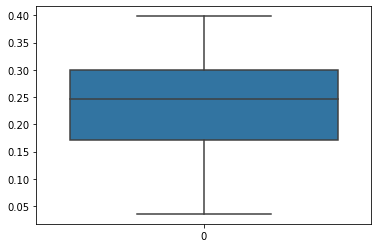

In [67]:
import seaborn as sns

ax = sns.boxplot(data=np.array(MAE_list).reshape(1,-1))

# XGBoost on Excitatory Cells Only

In [15]:
behaviors = ["Naive", "Virgin Parenting", "Parenting"]
sexes = ["Female"]

In [16]:
with open('animal_id.json') as json_file:
    animals = json.load(json_file)

In [19]:
# loss_dict = {}
time_dict = {}
loss_excitatory_dict = {}
# loss_inhibitory_dict = {}
gene_loss_dict = {}

for behavior in behaviors:
    for sex in sexes:
        try:
            animal_list = animals[behavior][sex]
        except KeyError:
            continue
        behavior = [behavior]
        sex = [sex]
        # print(behavior, sex, animal_list)
        for animal in animal_list:
            start = time.time()
            trial_run = FilteredMerfishDataset('data', sexes=sex, behaviors=behavior, test_animal=animal)
            print(sex, behavior, animal)
            datalist = trial_run.construct_graphs(3, True)
            print(len(datalist))
            start = time.time()

            train_dataset = None

            for batch in datalist:
                # gene expressions of cell i
                x = batch.x
                # position coordinate of gene i
                pos = batch.pos
                bregma = torch.tensor([batch.bregma]*pos.shape[0]).reshape(-1,1)

                # behavior and cell_type
                behavior_and_cell_type = batch.y

                # get the neighbors of the current batch
                neighbors = get_neighbors(batch)

                # get the sum of the ligand expressions for each cell in the current batch
                total_ligands = get_ligand_sum(x, neighbors, ligand_indeces)

                # get the proportion of celltypes as one-hot encoded vectors
                celltype_proportions = get_celltype_simplex(behavior_and_cell_type[:, 1], neighbors)

                # combine all the data
                X = torch.cat((x[:, non_response_indeces], total_ligands, pos, bregma, celltype_proportions), dim=1)
                excitatory_cells = (behavior_and_cell_type[:, 1] == 6).nonzero(as_tuple=True)[0]
                X = torch.index_select(X, 0, excitatory_cells)
#                 scaler = StandardScaler().fit(X)
#                 X = torch.tensor(scaler.transform(X))

                if train_dataset is None:
                    train_dataset = X
                    train_Y = torch.index_select(x[:, response_indeces], 0, excitatory_cells)
                else:
                    train_dataset = torch.cat((train_dataset, X), dim=0)
                    train_Y = torch.cat((train_Y, torch.index_select(x[:, response_indeces], 0, excitatory_cells)), dim=0)

                print(f"Batch: {datalist.index(batch)+1}/{len(datalist)}")
                
            scaler = StandardScaler().fit(train_dataset)
            train_dataset = torch.tensor(scaler.transform(train_dataset))

            assert train_dataset.shape[0] == train_Y.shape[0]

            test_datalist = trial_run.construct_graphs(3, False)

            test_dataset = None

            for batch in test_datalist:
                # gene expressions of cell i
                x = batch.x
                # position coordinate of gene i
                pos = batch.pos
                bregma = torch.tensor([batch.bregma]*pos.shape[0]).reshape(-1,1)

                # behavior and cell_type
                behavior_and_cell_type = batch.y

                # get the neighbors of the current batch
                neighbors = get_neighbors(batch)

                # get the sum of the ligand expressions for each cell in the current batch
                total_ligands = get_ligand_sum(x, neighbors, ligand_indeces)

                # get the proportion of celltypes as one-hot encoded vectors
                celltype_proportions = get_celltype_simplex(behavior_and_cell_type[:, 1], neighbors)

                # combine all the data
                test_X = torch.cat((x[:, non_response_indeces], total_ligands, pos, bregma, celltype_proportions), dim=1)

                # standardize the data using TRAINING mean and sd.
                excitatory_cells = (behavior_and_cell_type[:, 1] == 6).nonzero(as_tuple=True)[0]
                test_X = torch.index_select(test_X, 0, excitatory_cells)
#                 test_X = torch.tensor(scaler.transform(test_X))

                if test_dataset is None:
                    test_dataset = test_X
                    test_Y = torch.index_select(x[:, response_indeces], 0, excitatory_cells)
                    print(test_dataset.shape[0], test_Y.shape[0])
                else:
                    test_dataset = torch.cat((test_dataset, test_X), dim=0)
                    test_Y = torch.cat((test_Y, torch.index_select(x[:, response_indeces], 0, excitatory_cells)), dim=0)

                print(f"Batch: {test_datalist.index(batch)+1}/{len(test_datalist)}")

            test_dataset = torch.tensor(scaler.transform(test_dataset))
            
            assert test_dataset.shape[0] == test_Y.shape[0]

            model_list = []
            MAE_list = []

            # for each response gene in our response matrix....
            for i in range(train_Y.shape[1]):

                # create response gene variables
                y_i_train = train_Y[:, i]
                y_i_test = test_Y[:, i]
                
                if i == 0 and behavior == ["Naive"] and animal == 1:
                    print(f"trainY Mean: {torch.mean(y_i_train)}")
                    print(f"testY Mean: {torch.mean(y_i_test)}")

                # create XGBoost Regression Model
                model = xgb.XGBRegressor(tree_method="gpu_hist", nthread=1)

                # fit the regression model and add it to model list
                # print(train_dataset.shape, y_i_train.shape)
                model.fit(np.array(train_dataset), np.array(y_i_train))
                model_list.append((f"Gene {i}", model_list))

                # run the testing data through the model
                test_output = torch.tensor(model.predict(np.array(test_dataset)))

                # collect its MAE
                MAE_list.append(F.l1_loss(test_output, y_i_test))
                print(MAE_list[-1])
                print(f"Response Gene {merfish_df.columns[9:][response_indeces[i]]} MAE: {MAE_list[-1].item()}")
                gene_loss_dict[merfish_df.columns[9:][response_indeces[i]]] = MAE_list[-1].item()
                print(f"Response Gene: {i+1}/{train_Y.shape[1]}")

            end = time.time()
            time_dict[f"{sex}_{behavior}_{animal}"] = end-start
            loss_excitatory_dict[f"{sex}_{behavior}_{animal}"] = float(np.mean(MAE_list))

            with open("XGBoost_time.json", "w") as outfile:
                json.dump(time_dict, outfile, indent=4)

            with open("XGBoost_MAE_excitatory.json", "w") as outfile:
                json.dump(loss_excitatory_dict, outfile, indent=4)

            print(f"Test animal {animal} CV finished!")

Original Data (1027848, 170)
Filtered Data (205348, 170)
data/raw/merfish_messi.hdf5
['Female'] ['Naive'] 1
data/raw/merfish_messi.hdf5
23
There are 16 different cell types.
Batch: 1/23
There are 16 different cell types.
Batch: 2/23
There are 16 different cell types.
Batch: 3/23
There are 16 different cell types.
Batch: 4/23
There are 16 different cell types.
Batch: 5/23
There are 16 different cell types.
Batch: 6/23
There are 16 different cell types.
Batch: 7/23
There are 16 different cell types.
Batch: 8/23
There are 16 different cell types.
Batch: 9/23
There are 16 different cell types.
Batch: 10/23
There are 16 different cell types.
Batch: 11/23
There are 16 different cell types.
Batch: 12/23
There are 16 different cell types.
Batch: 13/23
There are 16 different cell types.
Batch: 14/23
There are 16 different cell types.
Batch: 15/23
There are 16 different cell types.
Batch: 16/23
There are 16 different cell types.
Batch: 17/23
There are 16 different cell types.
Batch: 18/23
There 

tensor(0.3408)
Response Gene Ttyh2 MAE: 0.3407709300518036
Response Gene: 80/84
tensor(0.0339)
Response Gene Mbp MAE: 0.033856336027383804
Response Gene: 81/84
tensor(0.0432)
Response Gene Nnat MAE: 0.043216269463300705
Response Gene: 82/84
tensor(0.1739)
Response Gene Sln MAE: 0.17394068837165833
Response Gene: 83/84
tensor(0.0559)
Response Gene Th MAE: 0.05593801289796829
Response Gene: 84/84
Test animal 1 CV finished!


KeyboardInterrupt: 

In [20]:
gene_loss_dict

{'Ace2': 0.18092699348926544,
 'Aldh1l1': 0.5517259836196899,
 'Amigo2': 0.631035327911377,
 'Ano3': 0.34114837646484375,
 'Aqp4': 0.5087195634841919,
 'Ar': 0.5941186547279358,
 'Arhgap36': 0.6908928155899048,
 'Baiap2': 0.5396795272827148,
 'Ccnd2': 0.5612232089042664,
 'Cd24a': 0.5419925451278687,
 'Cdkn1a': 0.44861364364624023,
 'Cenpe': 0.3097064197063446,
 'Chat': 0.2286856472492218,
 'Coch': 0.37949520349502563,
 'Col25a1': 0.7077867984771729,
 'Cplx3': 0.31097671389579773,
 'Cpne5': 0.6045604348182678,
 'Creb3l1': 0.43576645851135254,
 'Cspg5': 0.42512577772140503,
 'Cyp19a1': 0.25808021426200867,
 'Cyp26a1': 0.1436072289943695,
 'Dgkk': 0.6266689300537109,
 'Ebf3': 0.24607501924037933,
 'Egr2': 0.21281369030475616,
 'Ermn': 0.3088994324207306,
 'Esr1': 0.5049104690551758,
 'Etv1': 0.44846558570861816,
 'Fbxw13': 0.1890951544046402,
 'Fezf1': 0.39827996492385864,
 'Gbx2': 0.14393243193626404,
 'Gda': 0.6895920634269714,
 'Gem': 0.2949915826320648,
 'Gjc3': 0.4031409025192261,
 

In [75]:
assert list(merfish_df.columns[9:]).index("Ace2") == 0